# Continuation of Makemore - MLP - Back prop manually
The last tutorial was based on the following paper by [Bengio, et all](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and the lovely YouTube series by Andrej Karpathy. This goes forward with more on the MLP thinking through batch normalization and optimiazaion. 

In the last we made a bigram model through counts and a simple 1 layer NN. This time we will be following this paper to make a version of an MLP. 

I will be building out a similar to [this tool](https://github.com/karpathy/makemore/tree/master) from scratch. Note that I will be following the tutorial doing it step by step not looking at the final repo. 

Over all I will work through these papers:
- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762

Note that right now we don't write backward passes by hand :) It's still good to know though to be able to understand how to debug and avoid problems

In [2]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
%matplotlib inline

In [3]:
words = open("data/names.txt", "r").read().splitlines()
print(f'Total number of words: {len(words)}')
smallest = min(len(w) for w in words)
largest = max(len(w) for w in words)
print(f'Smallest Word is {smallest} char while the largest is {largest} char')

Total number of words: 32033
Smallest Word is 2 char while the largest is 15 char


In [4]:
# build the covabulary of chars and mappings 
chars = sorted(list(set(''.join(words))))
str_to_ind = {s:i + 1 for i,s in enumerate(chars)}
str_to_ind['.'] = 0
ind_to_str = {i:s for s,i in str_to_ind.items()}
print(ind_to_str)
vocab_size = len(ind_to_str)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        context = [0] * block_size # padded
        for ch in word + '.':
            ind = str_to_ind[ch]
            X.append(context)
            Y.append(ind)
            context = context[1:] + [ind] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size=3
X_train, Y_train = build_dataset(words[:n1], block_size=block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=block_size)
X_test, Y_test = build_dataset(words[n2:], block_size=block_size)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [23]:
def cmp(s, dt, t):
    exact = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad)
    max_diff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(exact):5s} | approximate: {str(approx):5s} | max diff: {max_diff}')

In [12]:
total_epochs = 0
lossi = []
n_emb_dim = 10
hidden_nodes = 200
input_size = n_emb_dim*block_size
gain = 5/3 
kaining_normal = gain / input_size**0.5

g = torch.Generator().manual_seed(2147483647) # reproducibility 
C = torch.randn((vocab_size, n_emb_dim), generator=g)

# Layer 1 
W1 = torch.randn((input_size, hidden_nodes),   generator=g) * kaining_normal    
b1 = torch.randn(hidden_nodes,                 generator=g) * 0.1 # scale this down to match 

# Layer 2
W2 = torch.randn((hidden_nodes,vocab_size),    generator=g) * 0.1 # useless but in for fun for this lecture
b2 = torch.randn(vocab_size,                   generator=g) * 0.1 # zero this out

# Batch norm
bngain = torch.ones((1, hidden_nodes)) * 0.1 + 1.0
bnbias = torch.zeros((1, hidden_nodes)) * 0.1

# Note: these are non standard init to make it more obvious 
# that the backpass was has any errors

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [13]:
batch_size = 32
epsilon = 1e-5
n = batch_size # convience short name

# mini batch
ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [15]:
# FORWARD PASS
# Note this is similar to before, but it has explicit instead of bass cross_entropy
# also it's brocken up more to create the back pross

emb = C[Xb]     
emb_concat = emb.view(emb.shape[0],-1)

# Linear layer 1 
hidden_pre_bn = emb_concat @W1 + b1

# Batch Norm
bn_mean_i = 1/n*hidden_pre_bn.sum(0, keepdim=True)
bn_diff = hidden_pre_bn - bn_mean_i
bn_diff_squared = bn_diff**2
bn_var = 1/(n-1) * bn_diff_squared.sum(0, keepdim=True) # note Bessesl's correction (divide by n-1)
bn_var_inv = (bn_var + epsilon)**-0.5
bn_raw = bn_diff * bn_var_inv
hidden_pre_act = bngain *bn_raw + bnbias

# non-linearity
hidden = torch.tanh(hidden_pre_act)

# Linear layer 2
logits = hidden @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = 
counts_sum_inv = counts_sum**-1 # this is to do bit exact
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts_sum_inv, counts_sum, counts,
          norm_logits, logit_maxes, logits, hidden, hidden_pre_act,
          bn_raw, bn_var_inv, bn_var, bn_diff_squared, bn_diff,
          bn_mean_i, hidden_pre_bn,emb_concat, emb
         ]:
    t.retain_grad()

loss.backward()
loss

tensor(3.6560, grad_fn=<NegBackward0>)

In [102]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n # only the one that are in the loss
dprobs = 1.0 / probs * dlogprobs
dcounts = counts_sum_inv * dprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv

dcounts += torch.ones_like(counts) * dcounts_sum 
dnorm_logits =  counts * dcounts # counts == e^x
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dlogits).sum(1, keepdim=True)

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T 
dW2 = hidden.T @ dlogits 
db2 = dlogits.sum(0, keepdim=True) 

dhpreact = (1.0 - hidden**2) * dh
dbngain = (bn_raw * dhpreact).sum(0, keepdim=True) 
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bn_diff * dbnraw).sum(0, keepdim=True)
dbndiff = bn_var_inv * dbnraw

dbnvar = -0.5 * (bn_var + epsilon)**-1.5 * dbnvar_inv
dbndiff2 = (1/(n-1)*torch.ones_like(bn_diff_squared)) * dbnvar
dbndiff += 2 * bn_diff * dbndiff2
dbnmeani = (-dbndiff).sum(0) 
dhprebn = dbndiff.clone()+ 1.0/n * (torch.ones_like(hidden_pre_act) * dbnmeani)

 # hidden_pre_bn = emb_concat @W1 + b1
dembcat = dhprebn @ W1.T
dW1 = emb_concat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C) 
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j] 

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('hidden', dh, hidden)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hidden_pre_act', dhpreact, hidden_pre_act)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bn_raw', dbnraw, bn_raw)
cmp('bnvar_inv', dbnvar_inv, bn_var_inv)
cmp('bnvar', dbnvar, bn_var)
cmp('bn_diff_squared', dbndiff2, bn_diff_squared)
cmp('bn_diff', dbndiff, bn_diff)
cmp('bn_mean_i', dbnmeani, bn_mean_i)
cmp('hidden_pre_bn', dhprebn, hidden_pre_bn)
cmp('emb_concat', dembcat, emb_concat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1) # note: this was done the same way but is failing
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | max diff: 0.0
probs           | exact: True  | approximate: True  | max diff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff: 0.0
counts_sum      | exact: True  | approximate: True  | max diff: 0.0
counts          | exact: True  | approximate: True  | max diff: 0.0
norm_logits     | exact: True  | approximate: True  | max diff: 0.0
logit_maxes     | exact: True  | approximate: True  | max diff: 0.0
logits          | exact: True  | approximate: True  | max diff: 0.0
hidden          | exact: True  | approximate: True  | max diff: 0.0
W2              | exact: True  | approximate: True  | max diff: 0.0
b2              | exact: True  | approximate: True  | max diff: 0.0
hidden_pre_act  | exact: True  | approximate: True  | max diff: 0.0
bngain          | exact: True  | approximate: True  | max diff: 0.0
bnbias          | exact: True  | approximate: True  | max diff: 0.0
bn_raw          | exact: True  | approximate: Tr

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [103]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.655993938446045 diff: -2.384185791015625e-07


In [104]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | max diff: 7.916241884231567e-09


In [105]:
dlogits[0] * n

tensor([ 0.0194,  0.0071,  0.0038,  0.0204,  0.1258, -0.9365,  0.0402,  0.0110,
         0.0333,  0.0056,  0.0066,  0.0051,  0.0188,  0.0876,  0.0055,  0.0028,
         0.0441,  0.0144,  0.0097,  0.0667,  0.0450,  0.0020,  0.2198,  0.1213,
         0.0069,  0.0123,  0.0013], grad_fn=<MulBackward0>)

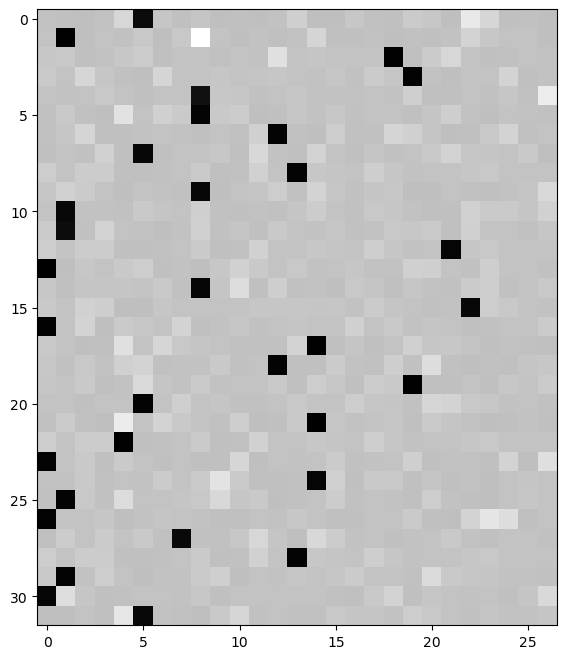

In [106]:
# dlogits are a force to pull down the probs of incorrect and pull up on the correct index
# the sum is zero though so it's equal.

plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [107]:
# Exercise 4 - doing the same for back norm

# forward pass
# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

NameError: name 'hprebn' is not defined

In [ ]:
epoch = 200000
learning_rate = 0.1
decay = 0.1
batch_size = 32
decay_threshold = 100000

for i in range(epoch):
    
    # minibatch contstruct, faster although not exact

    
    # forward
    emb = C[Xb]     
    emb_concat = emb.view(emb.shape[0],-1)
    hidden_pr e_activation = emb_concat @ W1
    
    # batch normlaizaiton
    hidden_mean = hidden_pre_activation.mean(0, keepdim=True)
    hidden_std = hidden_pre_activation.std(0, keepdim=True)
    hidden_pre_activation = bngain * (hidden_pre_activation - hidden_mean) / hidden_std + bnbias
    
    
    # calculate the running bmean and bstd, slight smoothing
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * hidden_mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * hidden_std
    
    hidden = torch.tanh(hidden_pre_activation)      
    logits = hidden @ W2 + b2                            
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None # zero_grade
        
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    if total_epochs > 0 and total_epochs%decay_threshold == 0:
        learning_rate *= decay
        
            
    if i % 10000 == 0 or i == epoch-1:
        print(f"epoch: {total_epochs:6} batch: {i:7}/{epoch:7} loss: {loss.item():5.3f}")

    # track stats
    lossi.append(loss.log10().item())
    total_epochs += 1
    